# High CO2 comparison
In this notebook, we'll compare the results presented in [Eisenhut M et al. 2017](https://www.cell.com/molecular-plant/pdf/S1674-2052(16)30219-2.pdf) for the transition from high to ambient CO2 with our transition from ambient oxygen to high oxygen. These conditions are comaprable because they both involve increasing photorespuratory flux by increasing the ratio of oxygen:CO2 available to rubisco. 

In [3]:
import pandas as pd
from os import listdir

The genes of interest are found in Table 1:

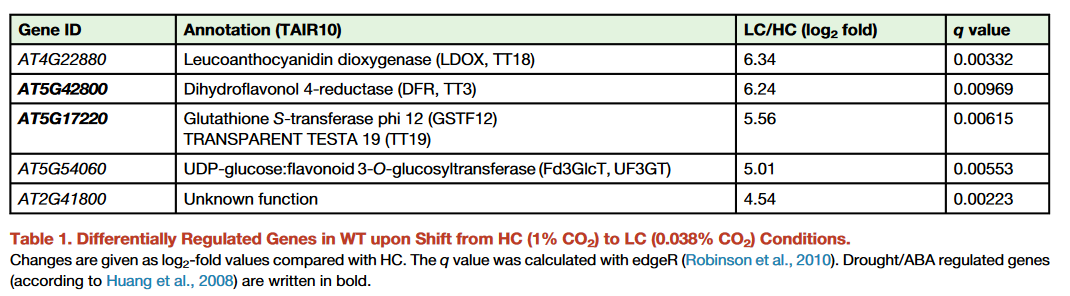

Do we find these differentially expressed in our 40% oxygen samples?

In [2]:
co2_genes = [
    'AT4G22880',
    'AT5G42800',
    'AT5G17220',
    'AT5G54060',
    'AT2G41800' 
]


We'll look both at the 7 hour and 1 hour timepoints separately as well as the filtered and unfiltered time conditions.

In [7]:
datapath = '../data/deseq2_output/'
forty = {}
for f in listdir(datapath):
    name = '_'.join(f.split('_')[:4])
    if '40' in name:
        forty[name] = pd.read_csv(datapath+f)

In [9]:
forty['1h_vs_7h_40o2_filtered'] = pd.read_csv('../data/deseq2_filtered/40_o2_7h_v_1h_filtered.csv')

In [10]:
for cond, df in forty.items():
    co2 = df[df['gene_id'].isin(co2_genes)]
    if len(co2) > 0:
        print(f'There are {len(co2)} high-to-ambient CO2 genes present at condition {cond}')

Looks like there's no overlap -- I'm not totally surprised, given how small the list of genes is from that paper (which in and of itself is surprising).